# LSTM Recurrent Neural Network
## Exploding Gradient in Vanilla RNN
Recall that our RNN model:

$$
h_{t} = tanh \left( W_{hh} h_{t-1} + W_{xh}x_{t} \right)
$$

$$
h_{t} = tanh \begin{pmatrix} (W_{hh} W_{xh}) \begin{pmatrix} h_{t-1} \\ x_{t} \end{pmatrix} \end{pmatrix}
$$

$$
h_{t} = tanh \begin{pmatrix} W \begin{pmatrix} h_{t-1} \\ x_{t} \end{pmatrix} \end{pmatrix}
$$

For every time step of a sequence, we backprogate from `h[t]` to `h[t-1]`. First the gradient will flow through the `tanh` gate and then to matrix multiplication gate. As we know, whenever we backprop into matrix multiplication gate, the upstream gradient is multiplied by the tranpose of the `W` matrix. This happens at every time step throughout the sequence. What if the sequence is very long?

![rnn-gradient-flow](assets/rnn-gradient-flow.png)

The final expression for gradient on `h[0]` will involve many factors of this weight matrix. This will either lead to an exploding gradient problem or vanishing gradient problem. There' a simple hack to address this problme, which is using `numpy.clip`. However, if the problem is vanishing gradient, clipping isn't going to help.

## Introducing LSTM

LSTM has a fancier recurrence relation than the vanilla RNN. LSTM has two states, one is being the usual hidden state `h[t]` we see in vanilla RNN and another one is called the cell state `c[t]`. Cell state is an internal vector that is not exposed to the outside world. 

Let's define some terminologies here: 

* `f` **forget gate**: whether to erase cell
* `i` **input gate**: whether to write to cell
* `g` **gate gate**: how much to write to cell
* `o` **output gate**: how much to reveal cell

$$
\begin{pmatrix} i \\ f \\ o \\ g \end{pmatrix} = \begin{pmatrix} \sigma \\ \sigma \\ \sigma \\ tanh \end{pmatrix}
W \begin{pmatrix} h_{t - 1} \\ x_{t} \end{pmatrix}
$$

**Note:** The sigma symbol represents sigmoid activation function.

The cell state is defined as following:

$$
\begin{aligned}
c_{t} &= f \odot c_{t - 1} + i \odot g \\
c_{t} &= \sigma(W_{hf} h_{t-1} + W_{xf} x_{t}) \odot c_{t-1} + \sigma(W_{hi} h_{t-1} + W_{xi} x_{t}) \odot tanh(W_{hg} h_{t-1} + W_{xg} x_{t})
\end{aligned}
$$

And the hidden state is a function of the cell state:

$$
\begin{aligned}
h_{t} &= o \odot tanh(c_{t}) \\
&= \sigma \begin{pmatrix} W_{hho} h_{t-1} + W_{xho} x_{t} \end{pmatrix} \odot tanh(c_{t})
\end{aligned}
$$

We take the previous cell state and hidden state as the inputs to our LSTM cell. The previous hidden state is combined with the input vector and multiply with the weight matrix to produce `ifog`. The forget gate multiplies element-wise with the previous cell state. The input and gate gate also multiply element wise. The two results are combined through sum elemenwise to produce a new cell state. The cell state is then squashed by a `tanh` and multiplied element-wise by the output gate to produce our next hidden state.

<img src="assets/lstm.png" width=400>

I omitted biases in above equations. Also, in some literatures, people tend to omit the `g` gate. In a non-matrix form, including biases, we can express the internal cell equations in the following way:

$$
f_{t} = \sigma \left(W_{hf}h_{t-1} + W_{xf}x + b_{f}\right) \\
i_{t} = \sigma \left(W_{hi}h_{t-1} + W_{xi}x + b_{i}\right) \\
o_{t} = \sigma \left(W_{ho}h_{t-1} + W_{xo}x + b_{o}\right)
$$

And compute the cell states and hidden states in the following way:

$$
c_{t} = f_{t} \odot c_{t-1} + i_{t} \odot \tanh \left( W_{gx}x + W_{gh}h_{t-1} + b_{g} \right) \\ 
h_{t} = o_{t} \odot tanh \left(c_{t} \right) 
$$



### LSTM Gradient Flow
Backpropagating from `c[t]` to `c[t-1]` is only element-wise multiplication by the `f` gate, and there is no matrix multiplication by W. The `f` gate is different at every time step, ranged between 0 and 1 due to sigmoid property, thus we have avoided of the problem of multiplying the same thing over and over again. 

Backpropagating from `h[t]` to `h[t-1]` is going through only one single `tanh` nonlinearity rather than `tanh` for every single step.

<img src="assets/cell-state-gradient-flow.png">

## LSTM Forward Propagation
The forward propagation isn't all that different from the vanilla recurrent neural network, we just now have more variables. Suppose we take a mini-batch of data, of shape `(N, T, D)`. `N` is our batch size, `T` is the size of the sequence, and `D` is the dimension of our input. 

For example, I have a sentence, `"hello world I am Calvin"`. We can treat this sentence as one input sequence with size `T=5` because it has five words. The dimension of the input depends on how we represent each word. Before we feed the sentence into a RNN, each word of a sentence has to be converted to a word vector which has dimension of `D`. 

### Word Vector Representation

In [1]:
import numpy as np

# Use null token to ensure each input sentence has the same length
raw_txt_inputs = ['hello world i am calvin', 'calvin says hello world <null>']
word_to_idx = dict()

idx = 0
for sentence in raw_txt_inputs:
    for word in sentence.split():
        if word_to_idx.get(word) is None:
            word_to_idx[word] = idx
            idx += 1

# Create a weight matrix for mapping word to its word vector representation
vocab_size = len(word_to_idx)
word_vec_dim = 5
word_embedding_weight = np.random.rand(vocab_size, word_vec_dim)

# Convert raw_txt_input to tensor representation
index_sequences = []
for sentence in raw_txt_inputs:
    seq = []
    for word in sentence.split():
        seq.append(word_to_idx[word])
    index_sequences.append(seq)

input_sequences = word_embedding_weight[np.array(index_sequences)]

print input_sequences
print '\nInput sequence has shape', input_sequences.shape

[[[ 0.55198998  0.54071806  0.90226677  0.20265959  0.46799276]
  [ 0.43116801  0.24566267  0.09201669  0.89917008  0.74025586]
  [ 0.89788589  0.38796635  0.69655404  0.99461356  0.51292432]
  [ 0.88489153  0.86448411  0.06838441  0.22403009  0.76379971]
  [ 0.26944088  0.92925252  0.08026437  0.11666287  0.38549861]]

 [[ 0.26944088  0.92925252  0.08026437  0.11666287  0.38549861]
  [ 0.3951689   0.11592959  0.51441416  0.55379455  0.55086654]
  [ 0.55198998  0.54071806  0.90226677  0.20265959  0.46799276]
  [ 0.43116801  0.24566267  0.09201669  0.89917008  0.74025586]
  [ 0.8989908   0.61441781  0.82226821  0.32174855  0.75626956]]]

Input sequence has shape (2, 5, 5)


### Forward Step & Sequence Example
When we pass a mini batch of sequences to the LSTM layer, we will run through the each word vector of each sequence through series of time step. In each time step, we perform the following forward propagation:
```python
def _forward_step(self, x, prev_hidden_state, prev_cell_state):
    """Forward pass for a single time step of the LSTM layer.

    :param np.array x: Input data of shape (N, D)
    :param np.array prev_hidden_state: Previous hidden state of shape (N, H)
    :param np.array prev_cell_state: Previous cell state of shape (N, H)

    Returns tuple:
        - next_hidden_state: Next hidden state, of shape (N, H)
        - next_cell_state: Next cell state, of shape (N, H)
        - cache: Tuple of values needed for back-propagation
    """
    _, H = prev_hidden_state.shape

    # Compute activations
    acts = np.dot(x, self.Wx) + np.dot(prev_hidden_state, self.Wh) + self.b

    # Compute the internal gates
    input_gate = sigmoid(acts[:, 0:H])
    forget_gate = sigmoid(acts[:, H:2*H])
    output_gate = sigmoid(acts[:, 2*H:3*H])
    gain_gate = np.tanh(acts[:, 3*H:4*H])

    # Compute next states
    next_cell_state = forget_gate * prev_cell_state + input_gate * gain_gate
    next_hidden_state = output_gate * np.tanh(next_cell_state)

    # Cache the results
    cache = {
        'x': x,
        'next-c': next_hidden_state,
        'next-h': next_cell_state,
        'i-gate': input_gate,
        'f-gate': forget_gate,
        'o-gate': output_gate,
        'g-gate': gain_gate,
        'prev-h': prev_hidden_state,
        'prev-c': prev_cell_state
    }

    return next_hidden_state, next_cell_state, cache
```

The cache is necessary for back propagation later. The forward propagation of a LSTM layer can be thought as breaking a sequence into time steps and feed each time step to the above code snippet.
```python
def forward(self, input_sequence, h0, Wx=None, Wh=None, b=None):
    """Forward pass for a LSTM layer over an entire sequence of data. 
    This assumes an input sequence composed of T vectors, each of dimension D. 
    The LSTM uses a hidden size of H, and it works over a mini-batch containing N sequences.

    :param np.array input_sequence: Input data of shape (N, T, D)
    :param np.array h0: Initial hidden state of shape (N, H)
    :param np.array Wx: Optional input-to-hidden weight matrix, of shape (D, 4H)
    :param np.array Wh: Optional hidden-to-hidden weight matrix, of shape (H, 4H)
    :param np.array b: Optional bias vector, of shape (4H,)

    Returns np.array:
        Hidden state over time of shape (N, T, H)
    """
    if Wx is not None and Wh is not None and b is not None:
        self.Wx, self.Wh, self.b = Wx, Wh, b

    N, T, D = input_sequence.shape
    _, H = h0.shape

    # Cache the inputs and create time series variables, 
    # i.e. hidden states over time and cell states over time.
    self.input_sequence = input_sequence
    self.h0 = h0

    self.hidden_states_over_t = np.zeros((N, T, H))        
    self.cell_states_over_t = np.zeros((N, T, H))
    self.caches = dict()

    # Run the sequence
    prev_hidden_state = h0
    prev_cell_state = np.zeros(h0.shape)
    for t in range(T):
        hidden_state, cell_state, self.caches[t] = self._forward_step(input_sequence[:, t, :],
                                                                     prev_hidden_state,
                                                                     prev_cell_state)
        self.hidden_states_over_t[:, t, :] = hidden_state
        self.cell_states_over_t[:, t, :] = cell_state

        prev_hidden_state, prev_cell_state = hidden_state, cell_state

    return self.hidden_states_over_t
```

## LSTM Back Propagation
We are given the following upstream gradients:

$$
\frac{\partial L}{\partial c_{t}} \;,\; \frac{\partial L}{\partial h_{t}}
$$

The objective is to find `ifog` gate gradients and matrix weight gradients:

$$
\frac{\partial L}{\partial i} \;,\;
\frac{\partial L}{\partial f} \;,\;
\frac{\partial L}{\partial o} \;,\;
\frac{\partial L}{\partial g} \;,\;
\frac{\partial L}{\partial W_{x}} \;,\;
\frac{\partial L}{\partial W_{h}} \;,\;
\frac{\partial L}{\partial b} \;,\;
\frac{\partial L}{\partial x} \;,\;
\frac{\partial L}{\partial h_{0}}
$$

Recall that `ifog` gates are declared as follows:
$$
\begin{pmatrix} i \\ f \\ o \\ g \end{pmatrix} = 
\begin{pmatrix} \sigma \\ \sigma \\ \sigma \\ tanh \end{pmatrix}
\left( \vec{x}W_{x} + \vec{h}_{t-1}W_{h} + b\right)
$$

The expected output of above calculation is a matrix of shape `(N, 4H)` where N is the mini-batch size and H is the hidden dimension. Using what we have above, we can compute the next cell state as follows:

$$
c_{t} = f \cdot c_{t-1} + i \cdot g
$$

With cell state, we can compute the next hidden state:

$$
h_{t} = o \cdot tanh\left(c_{t}\right)
$$

### Compute Gradients
Since we are given upstream gradients of loss with respect to output cell state and output hidden state, we will first compute gradients of hidden state with respect to cell state and gradient of new cell state with respect to old cell state.

$$
\frac{\partial h_{t}}{\partial c_{t}} = o \cdot (1 - tanh^{2}(c_{t}))
$$

$$
\frac{\partial c_{t}}{\partial c_{t - 1}} = f
$$

Now we can calculate gradient of loss with respect to previous cell state, which is a sum of contributions from both upstream gradients.

$$
\frac{\partial L}{\partial c_{t-1}} = \frac{\partial L}{\partial c_{t}} \frac{\partial c_{t}}{\partial c_{t-1}} +
\frac{\partial L}{\partial h_{t}} \frac{\partial h_{t}}{\partial c_{t}} \frac{\partial c_{t}}{\partial c_{t-1}}
$$

Proceed and compute gradients for `ifog` gates:

$$
\frac{\partial L}{\partial i} = \frac{\partial L}{\partial c_{t}} \frac{\partial c_{t}}{\partial i} + 
\frac{\partial L}{\partial h_{t}} \frac{\partial h_{t}}{\partial c_{t}} \frac{\partial c_{t}}{\partial i}
$$

$$
\frac{\partial L}{\partial f} = \frac{\partial L}{\partial c_{t}} \frac{\partial c_{t}}{\partial f} + 
\frac{\partial L}{\partial h_{t}} \frac{\partial h_{t}}{\partial c_{t}} \frac{\partial c_{t}}{\partial f}
$$

$$
\frac{\partial L}{\partial o} = \frac{\partial L}{\partial h_{t}} \frac{\partial h_{t}}{\partial o}
$$

$$
\frac{\partial L}{\partial g} = \frac{\partial L}{\partial c_{t}} \frac{\partial c_{t}}{\partial g} + 
\frac{\partial L}{\partial h_{t}} \frac{\partial h_{t}}{\partial c_{t}} \frac{\partial c_{t}}{\partial g}
$$

Continue to back-propagate and we are almost done! Compute the non-linearity for each of the `ifog` gates and then combine the gradients to form one combined matrix of shape `(N, 4H)`. We will call this our activiation matrix `A`. Then the following gradients can be obtained:

$$
\frac{\partial L}{\partial W_{x}} = \frac{\partial L}{\partial A} \frac{\partial A}{\partial W_{x}}
$$

$$
\frac{\partial L}{\partial W_{h}} = \frac{\partial L}{\partial A} \frac{\partial A}{\partial W_{h}}
$$

$$
\frac{\partial L}{\partial b} = \frac{\partial L}{\partial A} \frac{\partial A}{\partial b}
$$

$$
\frac{\partial L}{\partial x} = \frac{\partial L}{\partial A} \frac{\partial A}{\partial x}
$$

$$
\frac{\partial L}{\partial h_{0}} = \frac{\partial L}{\partial A} \frac{\partial A}{\partial h_{0}}
$$

### Backprop Step & Sequence Example
Using the cache from the forward propagation time step, we can compute gradients for each time step.

```python
def _backward_step(self, grad_next_hidden_state, grad_next_cell_state, cache):
    """Backward pass for a single time step of the LSTM layer.

    Args:
        grad_next_hidden_state (np.array): Gradient of next hidden state, of shape (N, H)
        grad_next_cell_state (np.array): Gradient of next cell state, of shape (N, H)
        cache (tuple): Cache object from the forward pass

    Returns tuple:
        - grad_x: Gradients of time step input, of shape (N, D)
        - grad_prev_hidden_state: Gradients of previous hidden state, of shape (N, H)
        - grad_prev_cell_state: Gradients of previous cell state, of shape (N, H)
        - grad_Wx: Gradients of input-to-hidden weights, of shape (D, 4H)
        - grad_Wh: Gradients of hidden-to-hidden weights, of shape (H, 4H)
        - grad_b: Gradients of bias, of shape (4H,)
    """
    x, _, next_c, i_gate, f_gate, o_gate, g_gate, prev_h, prev_c = cache

    # Note that grad_prev_c has two contributions, one from grad_next_cell_state and another one from 
    # grad_next_hidden_state
    grad_next_h_next_c = 
In [ ]:
o_gate * ( 1 - (np.tanh(next_c) * np.tanh(next_c)))

    grad_prev_cell_state = (grad_next_hidden_state * grad_next_h_next_c * f_gate) + (grad_next_cell_state * f_gate)

    # Each gate needs to go through the derivative of non-linearity
    grad_i_gate = (grad_next_hidden_state * grad_next_h_next_c * g_gate) + (grad_next_cell_state * g_gate)
    grad_i_gate = grad_i_gate * i_gate * (1 - i_gate)

    grad_f_gate = (grad_next_hidden_state * grad_next_h_next_c * prev_c) + (grad_next_cell_state * prev_c)
    grad_f_gate = grad_f_gate * f_gate * (1 - f_gate)

    grad_o_gate = grad_next_hidden_state * np.tanh(next_c)
    grad_o_gate = grad_o_gate * o_gate * (1 - o_gate)

    grad_g_gate = (grad_next_hidden_state * grad_next_h_next_c * i_gate) + (grad_next_cell_state * i_gate)
    grad_g_gate = grad_g_gate * (1 - g_gate * g_gate)

    # Now stack them
    grad_act = np.concatenate((grad_i_gate, grad_f_gate, grad_o_gate, grad_g_gate), axis=1)

    # And then do the same ol' gradient calculations
    grad_x = np.dot(grad_act, self.Wx.T)
    grad_prev_hidden_state = np.dot(grad_act, self.Wh.T)
    grad_Wx = np.dot(x.T, grad_act)
    grad_Wh = np.dot(prev_h.T, grad_act)
    grad_b = np.sum(grad_act, axis=0)

    return grad_x, grad_prev_hidden_state, grad_prev_cell_state, grad_Wx, grad_Wh, grad_b 
```

We will use the step function in the sequence function. We iterate through each hidden state over time in a reversed order, hence the name back propagation. Every backprop time step will give us a gradient value for each of our weights and biases. We accumulate them over the whole sequence. 
```python
def backward(self, grad_hidden_state_over_t):
    """Backward pass for a LSTM layer over an entire sequence of data.

    Args:
        grad_hidden_state (np.array): Upstream gradients of hidden states, of shape (N, T, H)

    Returns tuple:
        - grad_input_seq: Gradient of the input data, of shape (N, T, D)
        - grad_h0: Gradient of the initial hidden state, of shape (N, H)
        - grad_Wx: Gradient of input-to-hidden weight matrix, of shape (D, 4H)
        - grad_Wh: Gradient of hidden-to-hidden weight matrix, of shape (H, 4H)
        - grad_b: Gradient of biases, of shape (4H,)
    """
    N, T, H = grad_hidden_state_over_t.shape
    # grad_cell_state_over_t = np.zeros((N, T, H))

    grad_input_seq = np.zeros(self.input_sequence.shape)
    grad_Wx, grad_Wh, grad_b = np.zeros(self.Wx.shape), np.zeros(self.Wh.shape), np.zeros(self.b.shape)
    grad_prev_hidden_state = np.zeros((N, H))
    grad_prev_cell_state = np.zeros((N, H))

    for t in reversed(range(T)):
        time_step_result = self._backward_step(grad_hidden_state_over_t[:, t, :] + grad_prev_hidden_state,
                                               grad_prev_cell_state,
                                               self.caches[t])
        grad_input_seq[:, t, :] = time_step_result[0]
        grad_prev_hidden_state = time_step_result[1]
        grad_prev_cell_state = time_step_result[2]

        # Accumulate
        grad_Wx += time_step_result[3]
        grad_Wh += time_step_result[4]
        grad_b += time_step_result[5]

    # Gradient of the initial hidden state is the last grad_prev_hidden_state
    grad_h0 = grad_prev_hidden_state

    return grad_input_seq, grad_h0, grad_Wx, grad_Wh, grad_b
```

## Example Model
Here is a simple model that takes a matrix of word indices as inputs and produces a matrix of word indices. I made the model such that it can answer simple questions but don't expect it to be as smart as Alexa because it has no natural language model. All it does is that it takes a sequence of input and produces a sequence of output.

The archiecture is very simple, it has three layers
1. *Word Embedding Layer* - It converts word indices into vector representations.
2. *LSTM Layer* - It takes the word vectors and produces another set of word vectors.
3. *Affine Layer* - It takes the outputs and convert them into softmax scores

The softmax score is used to classify word vectors into the appropriate word index.

In [2]:
import matplotlib.pyplot as plt
%matplotlib inline

from rnn.lstm_recurrent_model import LSTMRecurrentModel
from rnn.lstm_solver import LSTMSolver
from rnn.data_util import load_word_based_text_input

x_filepath = 'rnn/datasets/questions.txt'
y_filepath = 'rnn/datasets/answers.txt'
seq_length = 30

questions, answers, word_to_idx, idx_to_word = load_word_based_text_input(x_filepath, y_filepath, seq_length)

feed_dict = {
    'training_x': questions,
    'training_y': answers
}

model = LSTMRecurrentModel(word_to_idx, idx_to_word)

Now we have our model defined, we will run a solver with **Adam** optimizer to train the model. 

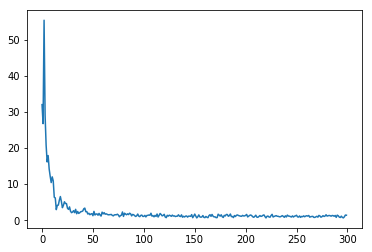

In [3]:
solver = LSTMSolver(model, feed_dict=feed_dict,
                           batch_size=10, 
                           num_epochs=300, 
                           print_every=10,
                           learning_rate_decay=0.99,
                           update_rule='adam',
                           verbose=False)
iters, losses = solver.train()

plt.plot(iters, losses)
plt.show()

In [21]:
from rnn.data_util import convert_string_to_index_matrix

input_sequence = convert_string_to_index_matrix("What did you eat?", word_to_idx)
model.sample(input_sequence)

input_sequence = convert_string_to_index_matrix("Where is the sky?", word_to_idx)
model.sample(input_sequence)

Q: What did you eat?
A: I ate your chocolate.
Q: Where is the sky?
A: She is blue.


Since I have so little data, I am still surprised that it can actually answer some basic questions. However, it is clearly not answering the questions in an intelligent manner. When I asked, *where is the sky?*, it tries to tell me what color is it. That is because in my training data, I only have one data point that has something to do with the sky.